In [12]:
import os
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.models import Model

from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Rescaling
import numpy as np
from keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
#import numpy as np 
#from sklearn import preprocessing

#from google.colab import drive
#drive.mount("/content/gdrive",force_remount=True)
physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_device

In [13]:
datagen = ImageDataGenerator( rotation_range=20, zoom_range=0.1,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1,
 fill_mode="nearest" ,preprocessing_function=preprocess_input,dtype="numpy.float32",rescale=1.0/255.0) 

ds_train = datagen.flow_from_directory( 
    '../input/dataset3/training/training',
      # categorical, binary
    classes=['real','fake'],
    color_mode="rgb",
    batch_size= 2,
    target_size=(224,224),  # reshape if not in this size
    shuffle=True,
    seed=123,
   subset="training",
)
data = ImageDataGenerator( preprocessing_function=preprocess_input,rescale=1.0/255.0,dtype="numpy.float32"  )

ds_valdiation =data.flow_from_directory(
    '../input/dataset3/validation/validation/',
      # categorical, binary
    classes=['real','fake'],
    color_mode="rgb",
    batch_size= 2,
    target_size=(224,224),
    #shuffle = False, # reshape if not in this size
    shuffle=True,
  seed=123,
)

ds_test= data.flow_from_directory(
    '../input/dataset3/test/test',
    classes=['real','fake'],
    color_mode="rgb",
    batch_size= 2,
    target_size=(224,224),#eshape if not in this size
 shuffle = False   

)
#scaler.fit_transform(ds_train)


Found 3741 images belonging to 2 classes.
Found 1858 images belonging to 2 classes.
Found 1565 images belonging to 2 classes.


In [27]:


vggmodel = VGG16(weights="imagenet", include_top=True,input_shape=(224,224,3))
#vggmodel.trainable = False ## Not trainable weights


X= vggmodel.layers[-2].output
#x1 = Normalizer(X)

#= Dense(8,activation="relu")(X) 
#x3= BatchNormalization()(x2)
x4 = Dropout(0.3)(X)
predictions = Dense(2, activation="softmax")(x4)

model_final = Model(vggmodel.input, predictions)
model_final.summary()
model_final.compile(loss="categorical_crossentropy", metrics ="accuracy",optimizer=keras.optimizers.Adam(learning_rate=1e-4))

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
hist=model_final.fit(ds_train,validation_data=ds_valdiation,epochs=50,batch_size=32,callbacks=[es],steps_per_epoch=100)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
model_final.evaluate(ds_train)
model_final.evaluate(ds_test)
model_final.evaluate(ds_valdiation)

929/929 [==============================] - 9s 10ms/step - loss: 0.4429 - accuracy: 0.9203


[0.4429078996181488, 0.9203444719314575]

In [29]:
model_json = model_final.to_json()
with open("vgg16.json", "w") as json_file:
    json_file.write(model_json)

In [17]:
model_final.save("./vgg16.h5")
from IPython.display import FileLink
FileLink(r'vgg16.h5')

/kaggle/working/vgg16.h5

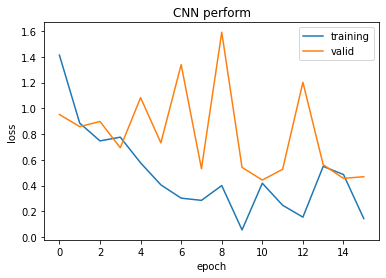

In [30]:
plt.plot(hist.history["loss"],label="training")
plt.plot (hist.history ["val_loss"],label="valid")
plt.title("CNN perform")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

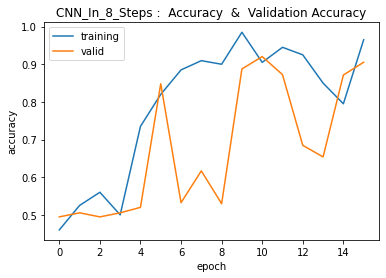

In [31]:
plt.plot(hist.history['accuracy'],label="training")
plt.plot(hist.history['val_accuracy'],label="valid")
plt.title('CNN_In_8_Steps :  Accuracy  &  Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()

Confusion Matrix
[[647 135]
 [ 66 717]]
Confusion Matrix_accurcy :
0.8715654952076677
classification_Report
              precision    recall  f1-score   support

        real       0.91      0.83      0.87       782
        fake       0.84      0.92      0.88       783

    accuracy                           0.87      1565
   macro avg       0.87      0.87      0.87      1565
weighted avg       0.87      0.87      0.87      1565



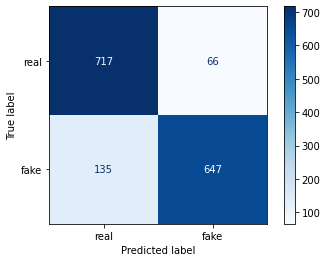

In [32]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
import numpy as np
target_names=['real','fake']
label_names = [1,0]

Y_pred =model_final.predict(ds_test)
y_pred = np.argmax(Y_pred ,  axis = 1)

cm = confusion_matrix(ds_test.classes, y_pred, labels = label_names)


print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred))
print('Confusion Matrix_accurcy :')

print(accuracy_score(ds_test.classes, y_pred))

print('classification_Report')
print(classification_report(ds_test.classes, y_pred, target_names=target_names))
#plot_confusion_matrix(ds_test,display_labels=target_names)

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()


In [21]:
print ()

In [22]:
for i in range(len(ds_train.classes)):
	print("test=%s, Predicted=%s" % (ds_train.classes[i], y_pred[i]))

test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0
test=0, Predicted=0


IndexError: index 1565 is out of bounds for axis 0 with size 1565